# 8-8. 프로젝트: 인물 모드 문제점 찾기
---

## Step 1. 인물 모드 직접 해보기

### 1. 라이브러리 불러오기

In [2]:
import cv2
import numpy as np
import os
import tarfile
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf

### 2. DeepLab Demo

In [199]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

In [200]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
                                                                   
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /aiffel/aiffel/human_segmentation/models
model loaded successfully!


In [201]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
np.where(np.array(LABEL_NAMES) == 'person')[0]

array([15])

### 3. 트와이스 사나의 이미지를 이용하여 인물 모드 해보기

#### (1) 이미지 불러오기

(2048, 1152, 3)


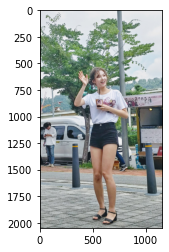

In [202]:
img_path_1 = os.getenv('HOME') + '/aiffel/human_segmentation/images/인물1.jpg'
img_orig_1 = cv2.imread(img_path_1)

print(img_orig_1.shape)

plt.imshow(cv2.cvtColor(img_orig_1, cv2.COLOR_BGR2RGB))
plt.show()

#### (2) 이미지를 네트워크에 입력하기

In [203]:
img_resized, seg_map = MODEL.run(img_orig_1)
print(img_orig_1.shape, img_resized.shape, seg_map.max())

(2048, 1152, 3) (513, 288, 3) 15


#### (3) 세그멘테이션 결과

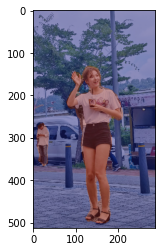

In [204]:
img_show= img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0)
img_mask = seg_map * (255 / seg_map.max())
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

In [205]:
cv2.imwrite('사나1.jpg', img_show)

True

#### (4) 세그멘테이션 결과를 원래 크기로 복원하기

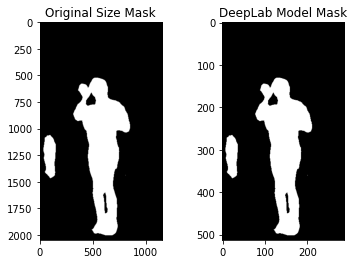

In [206]:
img_mask_up = cv2.resize(img_mask, img_orig_1.shape[:2][::-1], interpolation = cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1, 2, 1)
plt.imshow(img_mask_up, cmap = plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1, 2, 2)
plt.imshow(img_mask, cmap = plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

#### (5) 배경 흐리게 하기

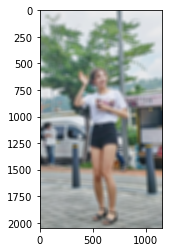

In [207]:
img_orig_1_blur = cv2.blur(img_orig_1, (40, 40))
plt.imshow(cv2.cvtColor(img_orig_1_blur, cv2.COLOR_BGR2RGB))
plt.show()

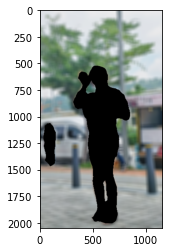

In [208]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_1_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

#### (6) 흐린 배경과 원본 이미지 합성

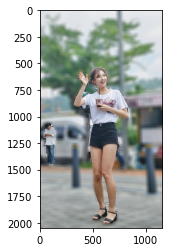

In [209]:
img_concat = np.where(img_mask_color == 255, img_orig_1, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

In [210]:
cv2.imwrite('사나2.jpg', img_concat)

True

### 4. 배우 송강의 이미지를 이용하여 인물 모드 해보기

#### (1) 이미지 불러오기

(960, 960, 3)


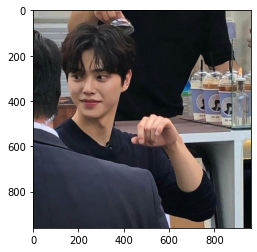

In [211]:
img_path_2 = os.getenv('HOME') + '/aiffel/human_segmentation/images/인물2.jpg'
img_orig_2 = cv2.imread(img_path_2)

print(img_orig_2.shape)

plt.imshow(cv2.cvtColor(img_orig_2, cv2.COLOR_BGR2RGB))
plt.show()

#### (2) 이미지를 네트워크에 입력하기

In [273]:
img_resized, seg_map = MODEL.run(img_orig_2)
print(img_orig_2.shape, img_resized.shape, seg_map.max())

(960, 960, 3) (513, 513, 3) 15


#### (3) 세그멘테이션 결과

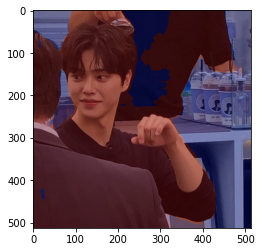

In [213]:
img_show= img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0)
img_mask = seg_map * (255 / seg_map.max())
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

In [214]:
cv2.imwrite('송강1.jpg', img_show)

True

#### (4) 세그멘테이션 결과를 원래 크기로 복원하기

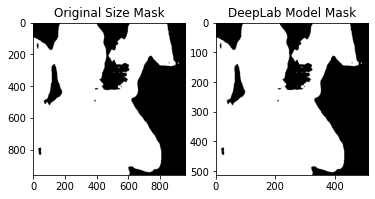

In [215]:
img_mask_up = cv2.resize(img_mask, img_orig_2.shape[:2][::-1], interpolation = cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1, 2, 1)
plt.imshow(img_mask_up, cmap = plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1, 2, 2)
plt.imshow(img_mask, cmap = plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

#### (5) 배경 흐리게 하기

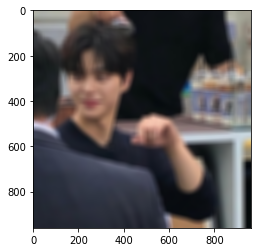

In [216]:
img_orig_2_blur = cv2.blur(img_orig_2, (30, 30))
plt.imshow(cv2.cvtColor(img_orig_2_blur, cv2.COLOR_BGR2RGB))
plt.show()

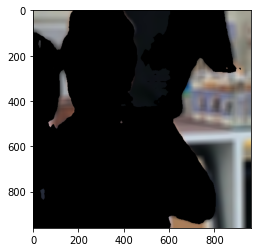

In [217]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_2_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

#### (6) 흐린 배경과 원본 이미지 합성

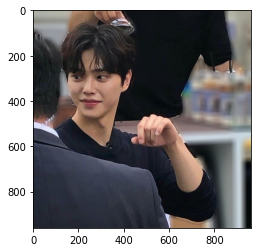

In [218]:
img_concat = np.where(img_mask_color == 255, img_orig_2, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

In [219]:
cv2.imwrite('송강2.jpg', img_concat)

True

### 5. 예능대세 이미주의 이미지를 이용하여 인물 모드 해보기

#### (1) 이미지 불러오기

(1024, 768, 3)


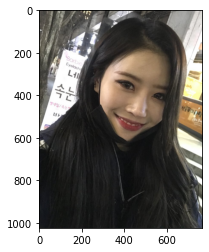

In [278]:
img_path_3 = os.getenv('HOME') + '/aiffel/human_segmentation/images/인물3.jpg'
img_orig_3 = cv2.imread(img_path_3)

print(img_orig_3.shape)

plt.imshow(cv2.cvtColor(img_orig_3, cv2.COLOR_BGR2RGB))
plt.show()

#### (2) 이미지를 네트워크에 입력하기

In [279]:
img_resized, seg_map = MODEL.run(img_orig_3)
print(img_orig_3.shape, img_resized.shape, seg_map.max())

(1024, 768, 3) (513, 384, 3) 15


#### (3) 세그멘테이션 결과

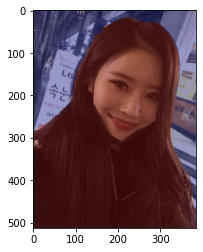

In [280]:
img_show= img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0)
img_mask = seg_map * (255 / seg_map.max())
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

#### (4) 세그멘테이션 결과를 원래 크기로 복원하기

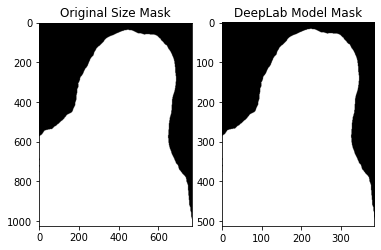

In [282]:
img_mask_up = cv2.resize(img_mask, img_orig_3.shape[:2][::-1], interpolation = cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1, 2, 1)
plt.imshow(img_mask_up, cmap = plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1, 2, 2)
plt.imshow(img_mask, cmap = plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

#### (5) 배경 흐리게 하기

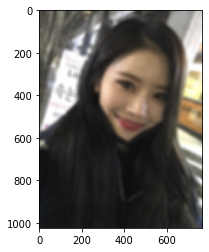

In [283]:
img_orig_3_blur = cv2.blur(img_orig_3, (20, 20))
plt.imshow(cv2.cvtColor(img_orig_3_blur, cv2.COLOR_BGR2RGB))
plt.show()

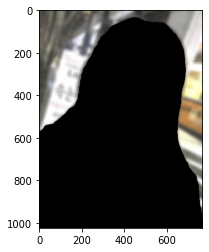

In [284]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_3_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

#### (6) 흐린 배경과 원본 이미지 합성

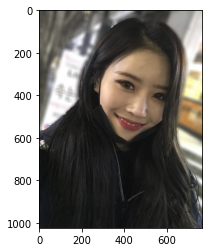

In [285]:
img_concat = np.where(img_mask_color == 255, img_orig_3, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

### 6. 고양이 이미지를 이용하여 인물 모드 해보기

#### (1) 이미지 불러오기

(399, 600, 3)


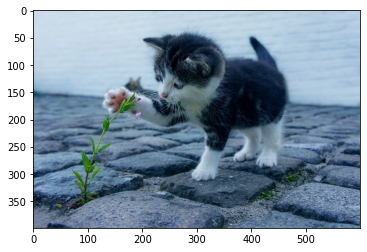

In [295]:
img_path_cat = os.getenv('HOME') + '/aiffel/human_segmentation/images/고양이.jpg'
img_orig_cat = cv2.imread(img_path_cat)

print(img_orig_cat.shape)

plt.imshow(cv2.cvtColor(img_orig_cat, cv2.COLOR_BGR2RGB))
plt.show()

#### (2) 이미지를 네트워크에 입력하기

In [296]:
img_resized, seg_map = MODEL.run(img_orig_cat)
print(img_orig_cat.shape, img_resized.shape, seg_map.max())

(399, 600, 3) (341, 513, 3) 8


#### (3) 세그멘테이션 결과

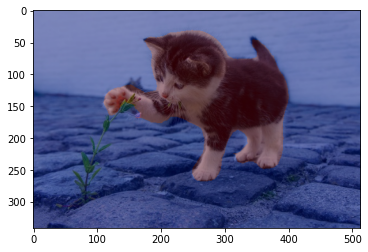

In [297]:
img_show= img_resized.copy()
seg_map = np.where(seg_map == 8, 8, 0)
img_mask = seg_map * (255 / seg_map.max())
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

#### (4) 세그멘테이션 결과를 원래 크기로 복원하기

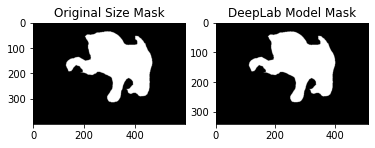

In [298]:
img_mask_up = cv2.resize(img_mask, img_orig_cat.shape[:2][::-1], interpolation = cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1, 2, 1)
plt.imshow(img_mask_up, cmap = plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1, 2, 2)
plt.imshow(img_mask, cmap = plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

#### (5) 배경 흐리게 하기

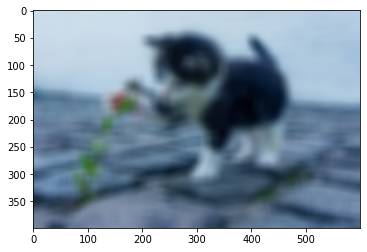

In [299]:
img_orig_cat_blur = cv2.blur(img_orig_cat, (20, 20))
plt.imshow(cv2.cvtColor(img_orig_cat_blur, cv2.COLOR_BGR2RGB))
plt.show()

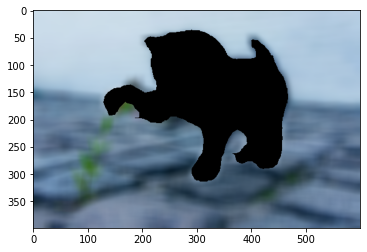

In [300]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_cat_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

#### (6) 흐린 배경과 원본 이미지 합성

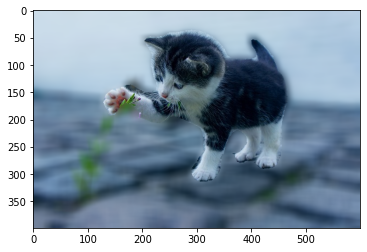

In [301]:
img_concat = np.where(img_mask_color == 255, img_orig_cat, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

### 7. 6번의 고양이 이미지에 다른 이미지로 크로마키 배경 합성 해보기

#### (1) 배경으로 이용할 이미지 불러오기

In [291]:
img_path_bg = os.getenv('HOME') + '/aiffel/human_segmentation/images/배경.jpg'
img_orig_bg = cv2.imread(img_path_bg)

print(img_orig_bg.shape)

(455, 728, 3)


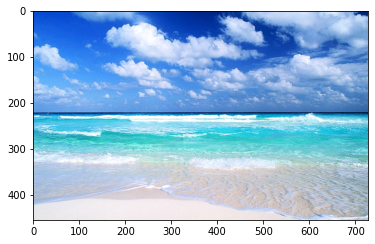

In [292]:
plt.imshow(cv2.cvtColor(img_orig_bg, cv2.COLOR_BGR2RGB))
plt.show()

#### (2) 배경 이미지 불러오기

In [293]:
img_concat = np.where(img_mask_color == 255, img_orig_cat, img_orig_bg)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

ValueError: operands could not be broadcast together with shapes (1024,768,3) (399,600,3) (455,728,3) 

* 불러 온 배경를 합성을 시도하였는데, 합성 할 고양이 이미지와 배경 이미지의 사이즈가 달라 합성이 진행이 되지 않았습니다. 이에 배경 이미지 사이즈를 조정하였습니다.

#### (3) 배경 이미지 조정하기

In [236]:
img_bg_resized = cv2.resize(img_orig_bg, dsize=(600, 399))

print(img_bg_resized.shape)

(399, 600, 3)


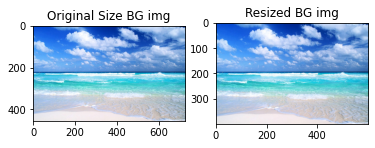

In [237]:
ax = plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img_orig_bg, cv2.COLOR_BGR2RGB))
ax.set_title('Original Size BG img')

ax = plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(img_bg_resized, cv2.COLOR_BGR2RGB))
ax.set_title('Resized BG img')

plt.show()

#### (4) 사이즈를 조정한 배경과 고양이 이미지 합성

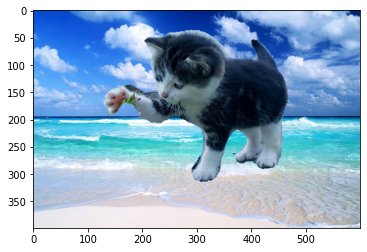

In [238]:
img_concat = np.where(img_mask_color == 255, img_orig_cat, img_bg_resized)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

* 이미지 합성시 합성할 이미지의 순서를 변경해보니, 고양이 이미지에 배경이 합성되었습니다.

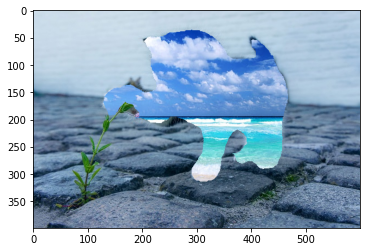

In [239]:
img_concat = np.where(img_mask_color == 255, img_bg_resized, img_orig_cat)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

## Step 2. 사진에서 문제점 찾기

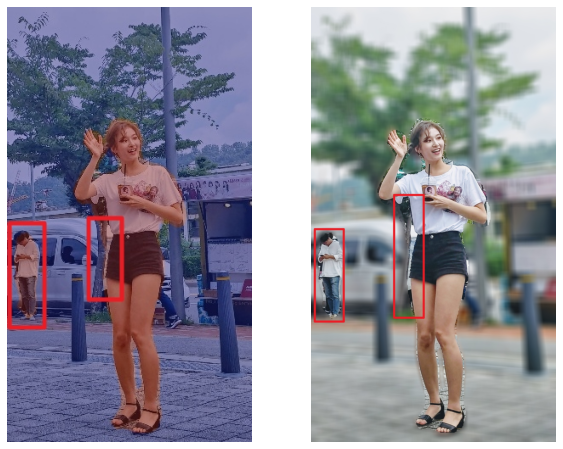

In [21]:
img_path = os.getenv('HOME') + '/aiffel/human_segmentation'
사나1 = cv2.imread(os.path.join(img_path,'사나1.jpg'))
사나2 = cv2.imread(os.path.join(img_path,'사나2.jpg'))

fig, ax = plt.subplots(figsize = (10, 8))

ax = plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(사나1, cv2.COLOR_BGR2RGB))
plt.axis('off')

ax = plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(사나2, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.show(ax)

트와이스의 사나 이미지에서 배경과 사나를 세그멘테이션하고자 하였습니다. 이때, 빨간상자 부분에서 처럼 사나 왼쪽과 나무 사이 부분이 사나로 라벨링 되었으며, 왼쪽에 있는 다른 사람도 함께 'person'으로 라벨링 되었고, 배경을 흐리게 하여 합성할 경우 'person'으로 라벨링 된 부분에 필요하지 않은 부분이 포함되었습니다. 

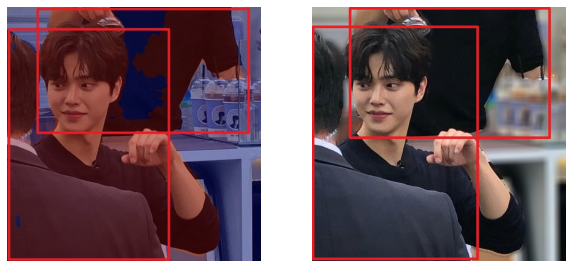

In [23]:
img_path = os.getenv('HOME') + '/aiffel/human_segmentation'
송강1 = cv2.imread(os.path.join(img_path,'송강1.jpg'))
송강2 = cv2.imread(os.path.join(img_path,'송강2.jpg'))

fig, ax = plt.subplots(figsize = (10, 8))

ax = plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(송강1, cv2.COLOR_BGR2RGB))
plt.axis('off')

ax = plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(송강2, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.show(ax)

배우 송강 역시 이미지에서도 배경과 송강을 세그멘테이션하고자 하였으나, 빨간상자 부분에서 처럼 다른 사람도 함께 'person'으로 라벨링 되었으며, 흐린 배경과 송강 배우를 합성시 불필요한 부분이 포함되어 합성이 되었습니다.